In [1]:
import numpy as np
from skimage import io, color, exposure, transform
from sklearn.cross_validation import train_test_split
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 14
IMG_SIZE = 32

/home/allenhsu/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img


def get_class(img_path):
    return int(img_path.split('$')[1])

In [22]:
try:
    with  h5py.File('X.h5') as hf: 
        X, y = hf['imgs'][:], hf['labels'][:]
    print("Loaded images from X.h5")
    
except (IOError,OSError, KeyError):  
    print("Error in reading X.h5. Processing all images...")
    root_dir = 'training_set/'
    imgs = []
    labels = []
    all_img_paths = glob.glob(os.path.join(root_dir, '*.png'))
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img)
            labels.append(label)

            if len(imgs)%1000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
        except (IOError, OSError):
            print('missed', img_path)
            pass

    X = np.array(imgs, dtype='float32')
    y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
    with h5py.File('X.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=y)

Error in reading X.h5. Processing all images...


/home/allenhsu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Processed 1000/3939
Processed 2000/3939
Processed 3000/3939


In [20]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()
# let's train the model using SGD + momentum (how original).
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

In [23]:
batch_size = 32
nb_epoch = 30

model.fit(X, y,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_split=0.2,
          shuffle=True,
          callbacks=[LearningRateScheduler(lr_schedule),
                    ModelCheckpoint('model.h5',save_best_only=True)]
            )

Train on 3151 samples, validate on 788 samples
Epoch 1/30
3151/3151 [==============================] - 1s 374us/step - loss: 0.0341 - acc: 0.9867 - val_loss: 0.0439 - val_acc: 0.9911
Epoch 2/30
3151/3151 [==============================] - 1s 351us/step - loss: 0.0348 - acc: 0.9870 - val_loss: 0.0257 - val_acc: 0.9937
Epoch 3/30
3151/3151 [==============================] - 1s 339us/step - loss: 0.0349 - acc: 0.9892 - val_loss: 0.0261 - val_acc: 0.9949
Epoch 4/30
3151/3151 [==============================] - 1s 346us/step - loss: 0.0201 - acc: 0.9930 - val_loss: 0.0339 - val_acc: 0.9949
Epoch 5/30
3151/3151 [==============================] - 1s 348us/step - loss: 0.0230 - acc: 0.9924 - val_loss: 0.0324 - val_acc: 0.9924
Epoch 6/30
3151/3151 [==============================] - 1s 347us/step - loss: 0.0266 - acc: 0.9917 - val_loss: 0.0350 - val_acc: 0.9898
Epoch 7/30
3151/3151 [==============================] - 1s 354us/step - loss: 0.0238 - acc: 0.9914 - val_loss: 0.0297 - val_acc: 0.9937
E

In [24]:
root_dir = 'testing_set/'
X_test = []
y_test = []
all_img_paths = glob.glob(os.path.join(root_dir, '*.png'))
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    try:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        X_test.append(img)
        y_test.append(label)

        if len(imgs)%1000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
    except (IOError, OSError):
        print('missed', img_path)
        pass

X_test = np.array(X_test)
y_test = np.array(y_test)

/home/allenhsu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [25]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9870967741935484


In [26]:
from sklearn.cross_validation import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(featurewise_center=False, 
                             featurewise_std_normalization=False, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.,)

datagen.fit(X_train)

In [27]:
model = cnn_model()
# let's train the model using SGD + momentum (how original).
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

In [28]:
nb_epoch = 30
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0],
                            epochs=nb_epoch,
                            validation_data=(X_val, y_val),
                            callbacks=[LearningRateScheduler(lr_schedule),
                                       ModelCheckpoint('model.h5',save_best_only=True)]
                           )

Epoch 1/30
3151/3151 [==============================] - 41s 13ms/step - loss: 0.2863 - acc: 0.9059 - val_loss: 0.0161 - val_acc: 0.9962
Epoch 2/30
3151/3151 [==============================] - 39s 13ms/step - loss: 0.0557 - acc: 0.9814 - val_loss: 0.0167 - val_acc: 0.9937
Epoch 3/30
3151/3151 [==============================] - 39s 12ms/step - loss: 0.0392 - acc: 0.9869 - val_loss: 0.0073 - val_acc: 0.9975
Epoch 4/30
3151/3151 [==============================] - 39s 13ms/step - loss: 0.0297 - acc: 0.9902 - val_loss: 0.0125 - val_acc: 0.9949
Epoch 5/30
3151/3151 [==============================] - 40s 13ms/step - loss: 0.0238 - acc: 0.9923 - val_loss: 0.0083 - val_acc: 0.9975
Epoch 6/30
3151/3151 [==============================] - 40s 13ms/step - loss: 0.0245 - acc: 0.9920 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 7/30
3151/3151 [==============================] - 40s 13ms/step - loss: 0.0180 - acc: 0.9940 - val_loss: 0.0035 - val_acc: 0.9987
Epoch 8/30
3151/3151 [==========================

In [29]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9956989247311828


In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 30, 30)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 15, 15)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 15, 15)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 13, 13)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 6, 6)          0         
__________

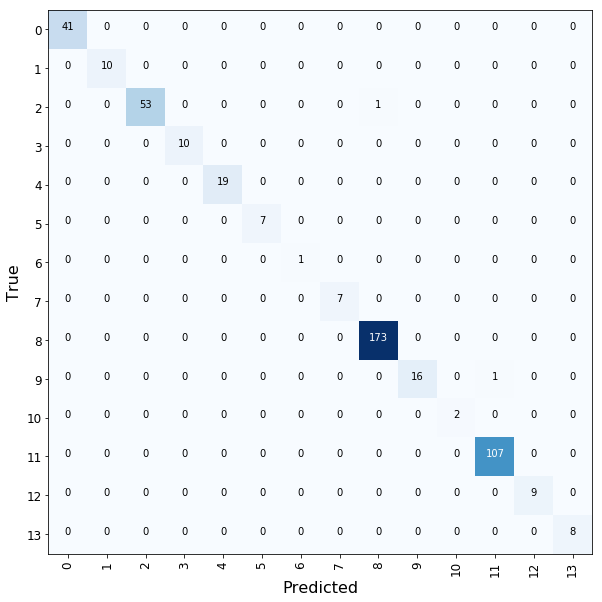

In [37]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,10))  
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(NUM_CLASSES)

plt.xticks(range(NUM_CLASSES))
plt.yticks(range(NUM_CLASSES))
plt.xticks(rotation=90)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Predicted', fontsize = 16)
plt.ylabel('True', fontsize= 16)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.show()
